## Voiceprint Verification Model Overview

- Load raw audio samples of approved phrases.
- Apply audio augmentations (pitch shift, time stretch, noise) to increase data variety.
- Extract features such as MFCCs, spectral roll-off, and energy.
- Train a classifier (e.g., Random Forest) on extracted audio features.
- Verify user identity by matching voiceprint from new audio samples.


In [45]:
# Import core libraries for audio processing and feature extraction
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
from IPython.display import Audio, display


In [46]:
# Function to load and play an audio file
def load_and_play_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    print(f"Loaded '{file_path}' (Sample Rate: {sr} Hz, Duration: {len(y)/sr:.2f}s)")
    display(Audio(y, rate=sr))
    return y, sr

# Example: Play each member's audio
y1, sr1 = load_and_play_audio('../data/raw/audio/member 1/Yes_approve.opus')
y2, sr2 = load_and_play_audio('../data/raw/audio/member 2/Yes_approve.opus')
y3, sr3 = load_and_play_audio('../data/raw/audio/member 3/Confirm_transaction.opus')
y4, sr4 = load_and_play_audio('../data/raw/audio/member 4/Confirm_transaction.opus')


Loaded '../data/raw/audio/member 1/Yes_approve.opus' (Sample Rate: 16000 Hz, Duration: 3.68s)


Loaded '../data/raw/audio/member 2/Yes_approve.opus' (Sample Rate: 16000 Hz, Duration: 3.28s)


Loaded '../data/raw/audio/member 3/Confirm_transaction.opus' (Sample Rate: 16000 Hz, Duration: 3.17s)


Loaded '../data/raw/audio/member 4/Confirm_transaction.opus' (Sample Rate: 16000 Hz, Duration: 4.42s)


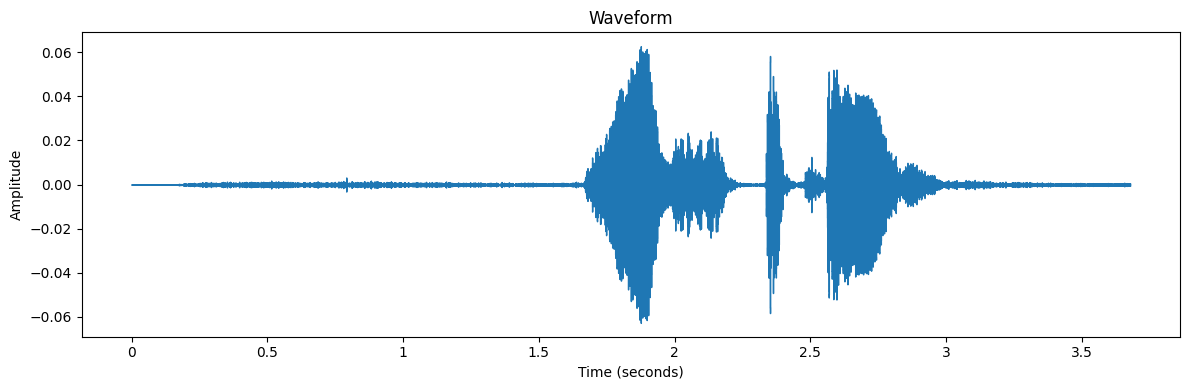

In [47]:
# Function to visualize waveform
def plot_waveform(y, sr, title="Waveform"):
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

# Example usage
plot_waveform(y1, sr1)


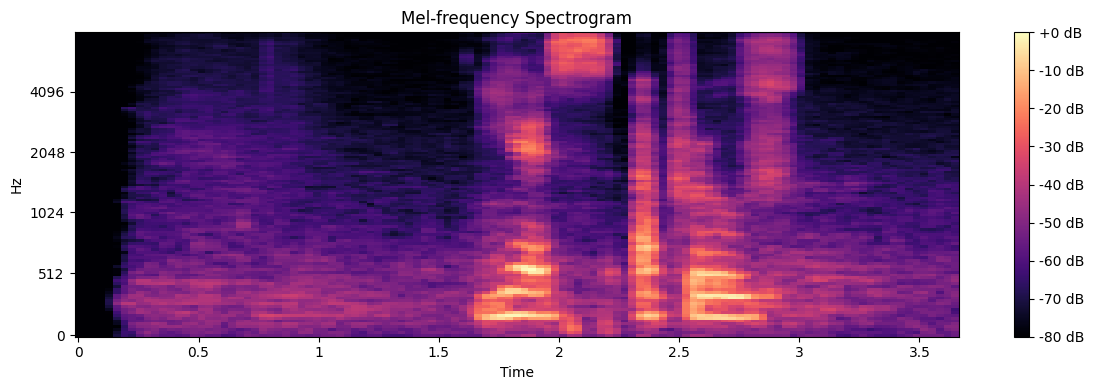

In [48]:
# Function to visualize frequency energy using Mel Spectrogram
def plot_mel_spectrogram(y, sr, title="Mel-frequency Spectrogram"):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example usage
plot_mel_spectrogram(y1, sr1)


In [49]:
# Extract MFCCs, roll-off, and energy from all audios in folder
def extract_features_from_folder(audio_dir, output_csv="audio_features.csv"):
    features = []
    for subdir, _, files in os.walk(audio_dir):
        for file in files:
            if file.lower().endswith(('.wav', '.opus')):
                file_path = os.path.join(subdir, file)
                y, sr = librosa.load(file_path, sr=None)

                # Compute features
                mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
                rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
                energy = np.sum(y ** 2) / len(y)

                # Label from folder name (member)
                label = os.path.basename(subdir)

                # Combine features
                feature_row = np.append(mfccs, [rolloff, energy, label])
                features.append(feature_row)

    # Build DataFrame
    columns = [f"mfcc_{i+1}" for i in range(13)] + ["rolloff", "energy", "label"]
    df = pd.DataFrame(features, columns=columns)
    df.to_csv(output_csv, index=False)
    print(f"✅ Features extracted and saved to {output_csv} ({len(df)} samples).")

# Example usage
extract_features_from_folder('../data/raw/audio/')


✅ Features extracted and saved to audio_features.csv (8 samples).


🎧 Visualizing: Confirm_transaction.opus


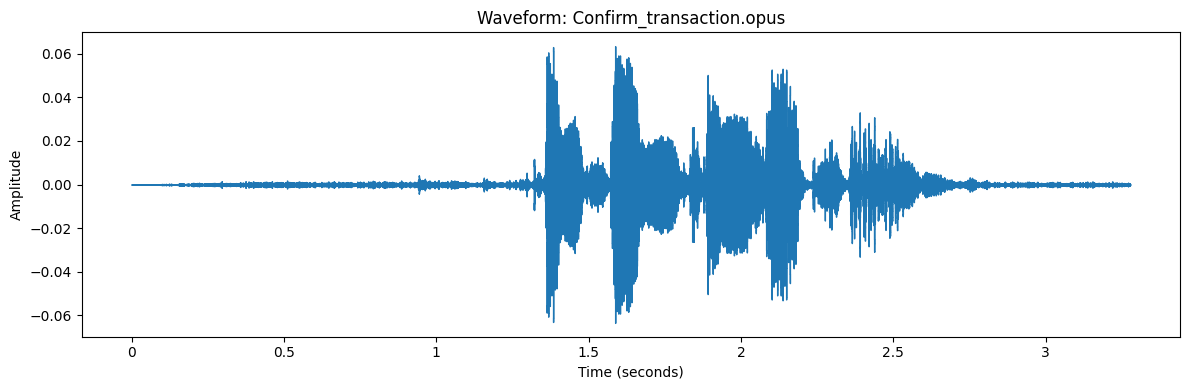

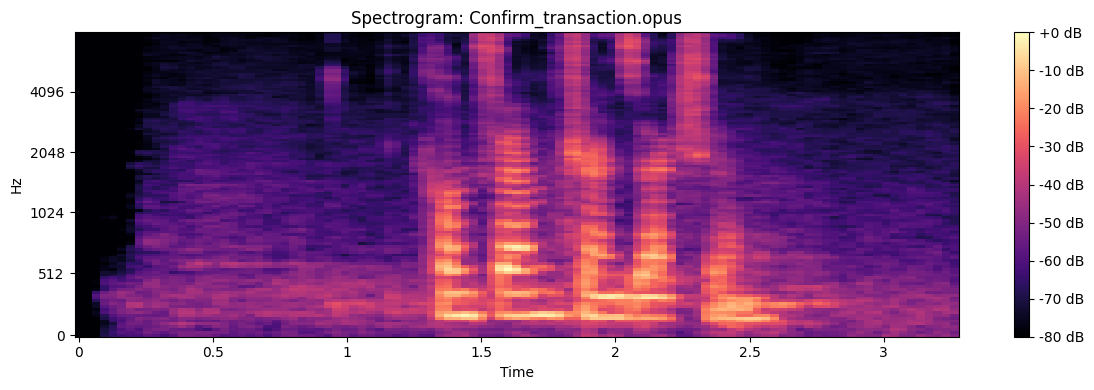

🎧 Visualizing: Yes_approve.opus


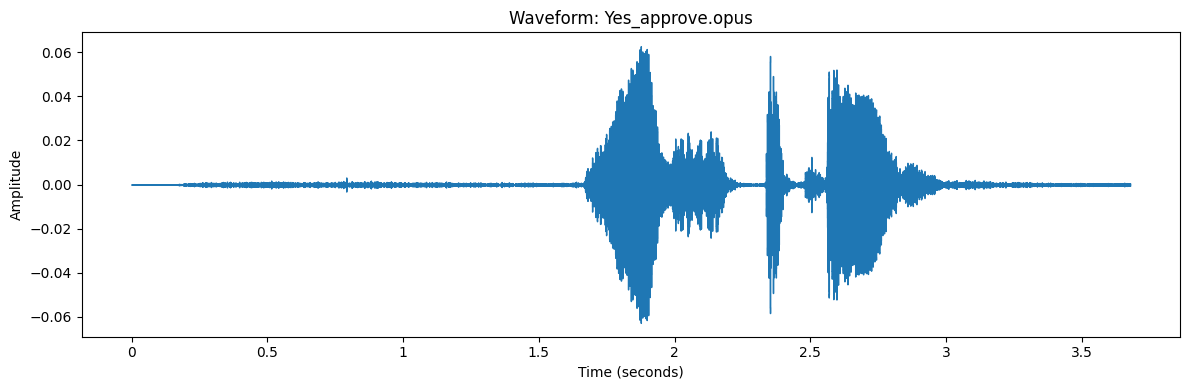

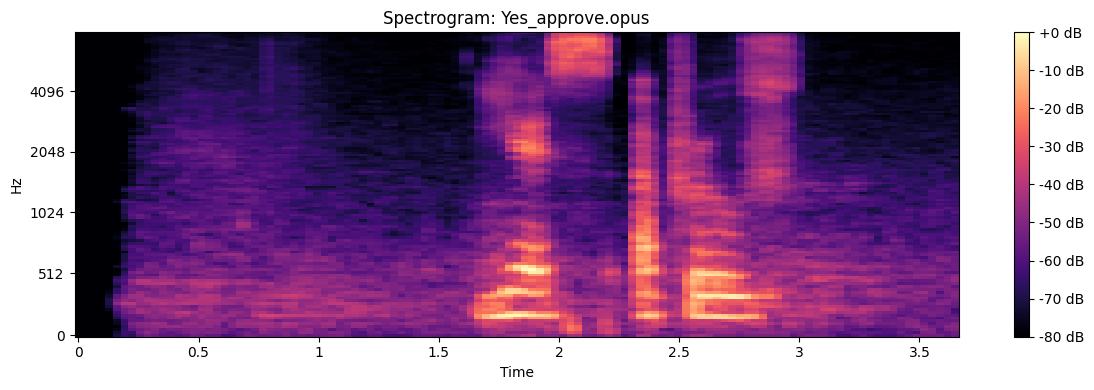

🎧 Visualizing: Confirm_transaction.opus


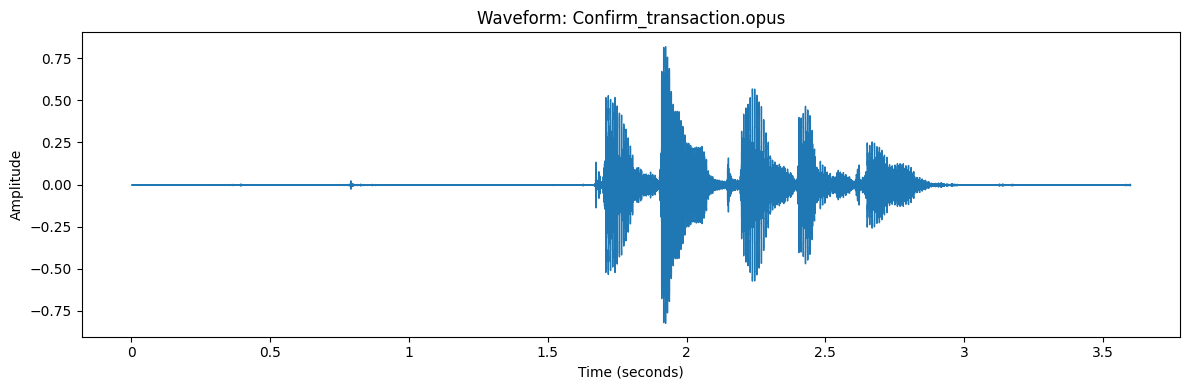

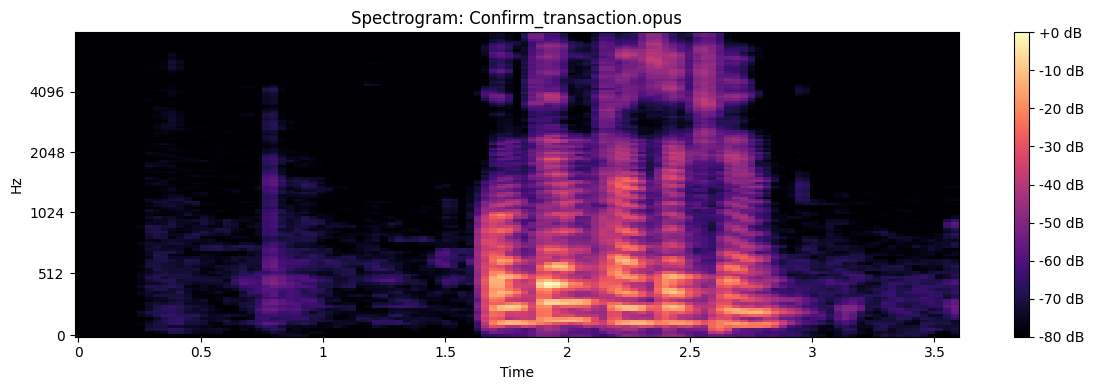

🎧 Visualizing: Yes_approve.opus


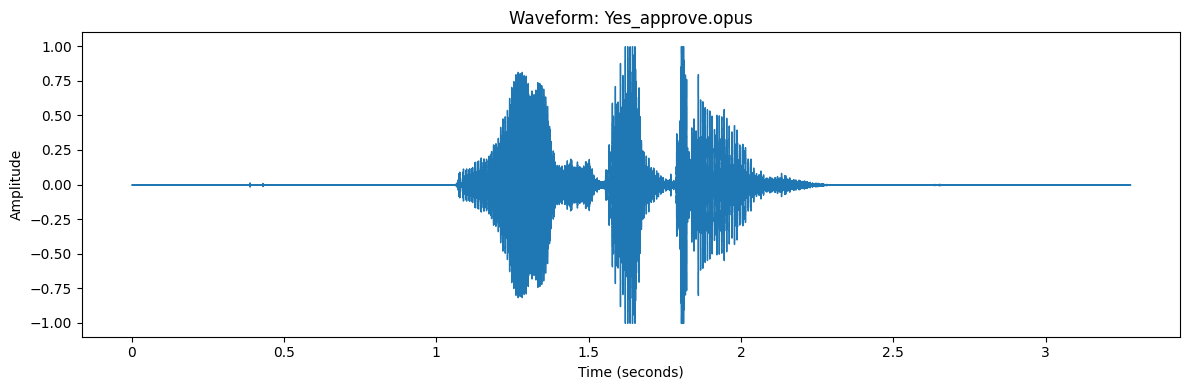

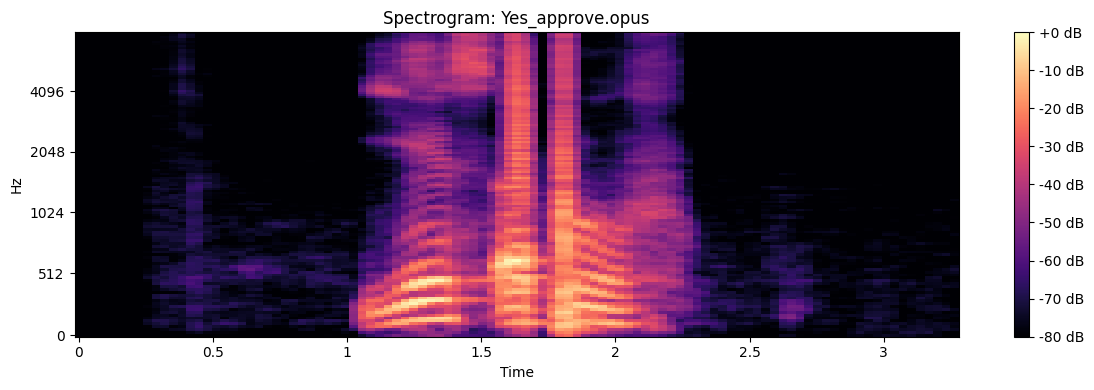

🎧 Visualizing: Confirm_transaction.opus


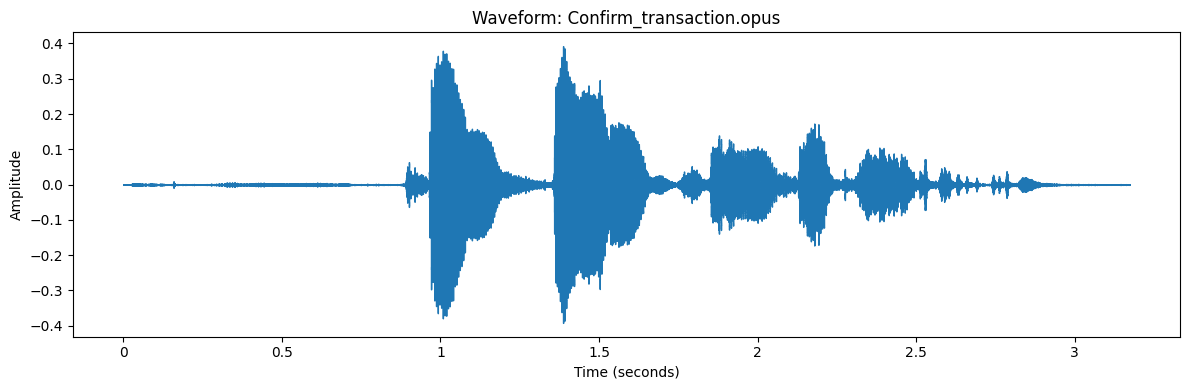

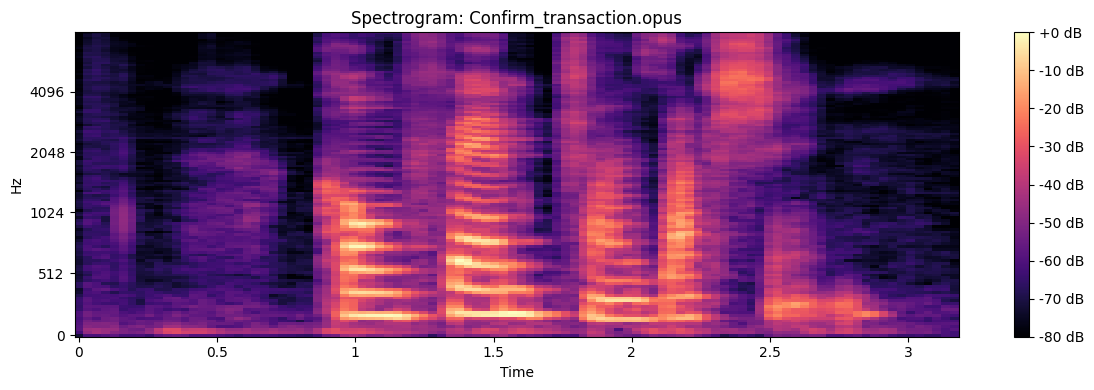

🎧 Visualizing: Yes_approve.opus


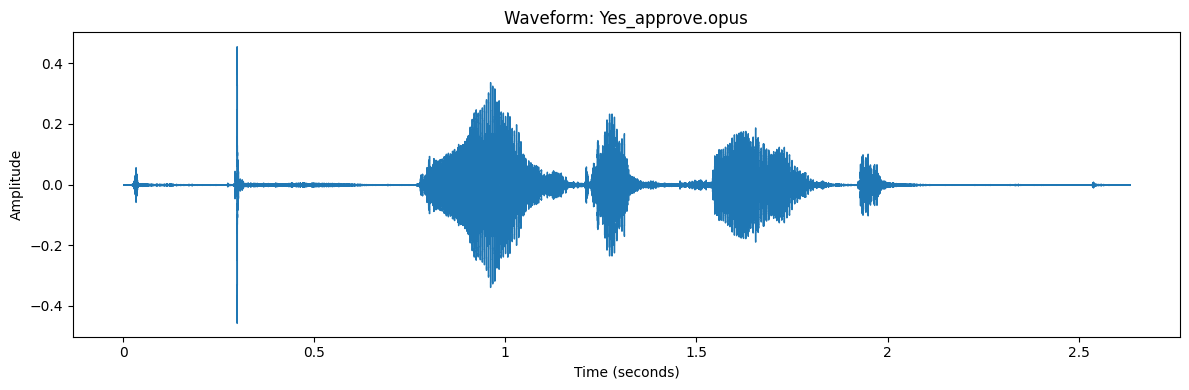

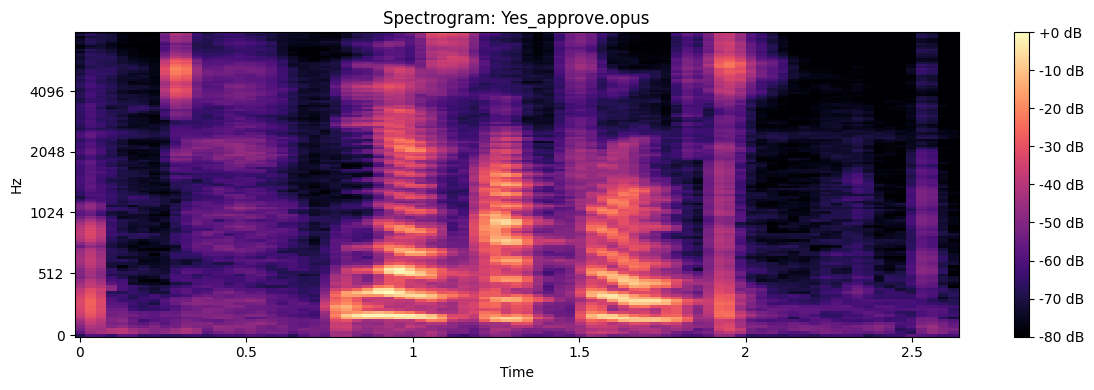

🎧 Visualizing: Confirm_transaction.opus


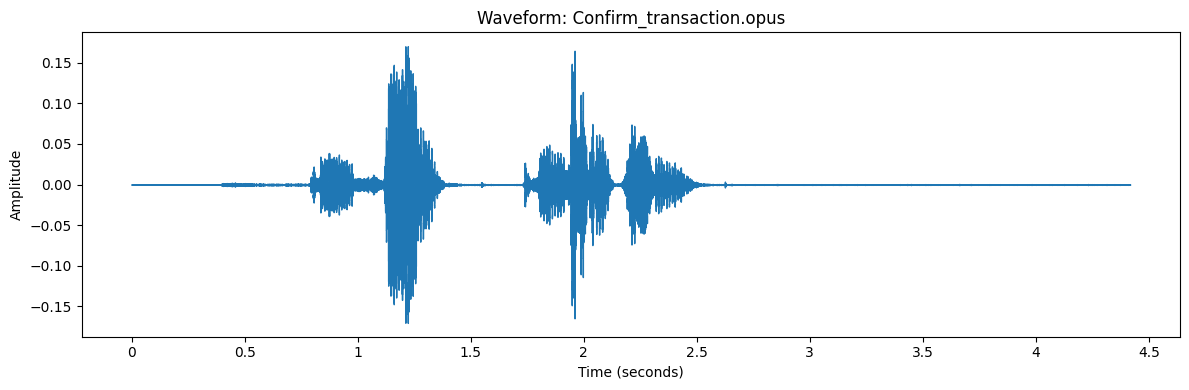

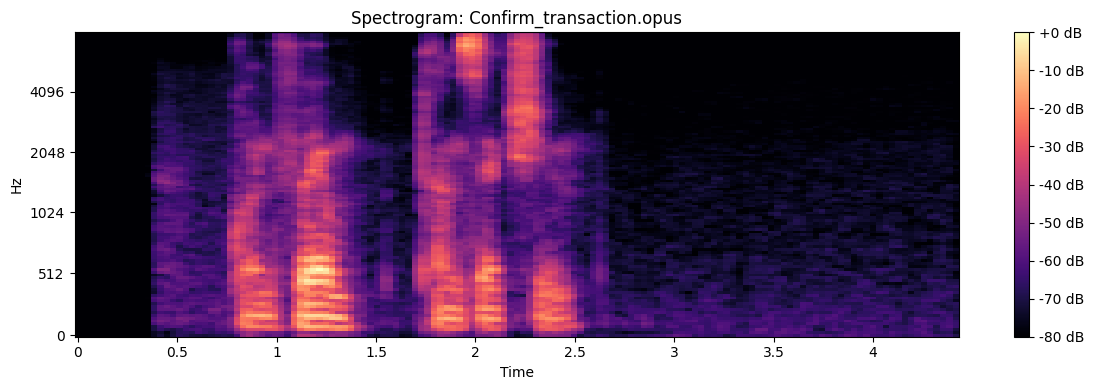

🎧 Visualizing: Yes_approve.opus


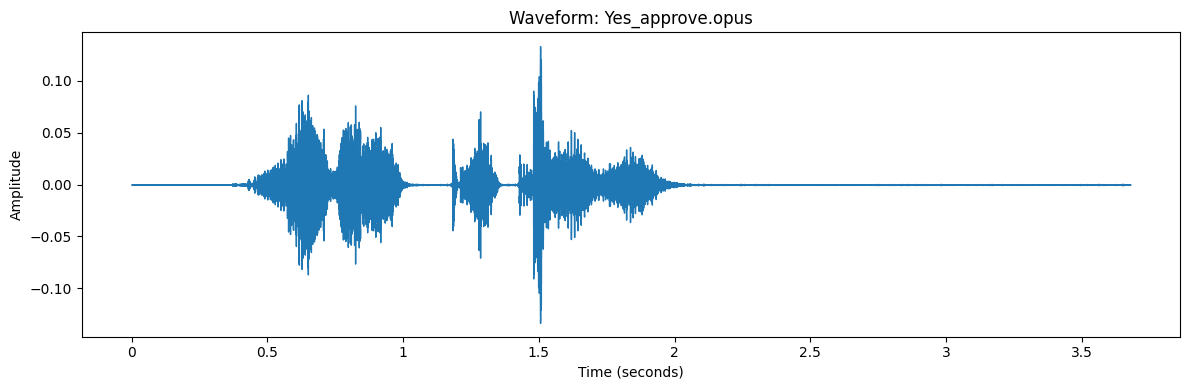

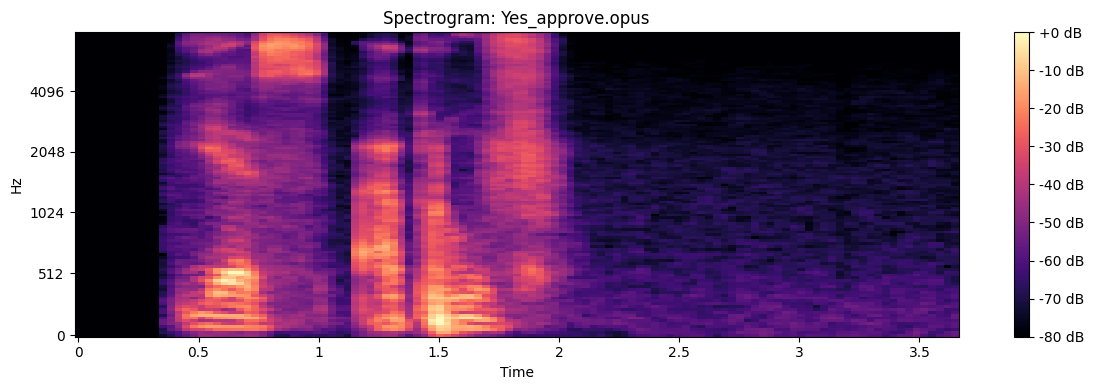

In [50]:
# Visualize all audio files (waveform + spectrogram)
def visualize_audio_folder(audio_dir):
    for subdir, _, files in os.walk(audio_dir):
        for file in files:
            if file.lower().endswith(('.wav', '.opus')):
                file_path = os.path.join(subdir, file)
                print(f"🎧 Visualizing: {file}")
                y, sr = librosa.load(file_path, sr=None)
                plot_waveform(y, sr, title=f"Waveform: {file}")
                plot_mel_spectrogram(y, sr, title=f"Spectrogram: {file}")

# Example usage
visualize_audio_folder('../data/raw/audio/')


In [54]:
# Apply 2+ augmentations (pitch, stretch, noise) and extract features
def extract_features(y, sr, label):
    """Extract MFCC, rolloff, and energy features for a single audio."""
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    energy = np.sum(y ** 2) / len(y)
    feature_dict = {f"mfcc_{i+1}": mf for i, mf in enumerate(mfccs)}
    feature_dict.update({"rolloff": rolloff, "energy": energy, "label": label})
    return feature_dict

def augment_audio(y, sr):
    """Apply time-stretch, pitch-shift, and noise augmentations."""
    augmentations = []
    augmentations.append(librosa.effects.pitch_shift(y, sr, n_steps=random.choice([-2, 2])))
    augmentations.append(librosa.effects.time_stretch(y, rate=random.choice([0.8, 1.2])))
    noise = np.random.randn(len(y))
    augmentations.append(y + 0.005 * noise)
    return augmentations

# Extract and save augmented features
audio_dir = '../data/raw/audio/'
all_features = []

for subdir, _, files in os.walk(audio_dir):
    for file in files:
        if file.lower().endswith(('.wav', '.opus')):
            label = os.path.basename(subdir)
            y, sr = librosa.load(os.path.join(subdir, file), sr=None)
            all_features.append(extract_features(y, sr, label + "_original"))
            try:
                augmentations = augment_audio(y, sr)
            except Exception as e:
                print(f"Warning: augment_audio failed for {file}: {e}")
                augmentations = []
            for i, aug in enumerate(augmentations):
                # Ensure augmented audio matches original length (pad or trim)
                if len(aug) != len(y):
                    if len(aug) > len(y):
                        aug = aug[:len(y)]
                    else:
                        aug = np.pad(aug, (0, len(y) - len(aug)), mode='constant')
                all_features.append(extract_features(aug, sr, f"{label}_aug{i+1}"))

df = pd.DataFrame(all_features)
df.to_csv("audio_features.csv", index=False)
print("✅ Features extracted and saved to 'audio_features.csv'")
df.head()


✅ Features extracted and saved to 'audio_features.csv'


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,rolloff,energy,label
0,-540.240967,100.011879,14.878708,12.524996,5.641113,-7.004230,-13.305945,-6.440949,-7.294043,-8.634644,-8.038005,-7.892732,-8.385885,3538.379854,0.000066,member 1_original
1,-578.867981,90.466316,23.058048,13.115257,1.817453,-7.139947,-14.566556,-5.206784,-9.776480,-5.123213,-1.430303,-5.373775,-5.492309,3910.733696,0.000048,member 1_original
2,-416.643646,61.744576,23.107286,1.514603,0.410255,-4.004648,-16.166838,-4.180311,-7.283148,-7.262041,-2.616419,-1.130092,-7.962512,4497.234513,0.004368,member 2_original
3,-393.458252,50.215450,24.601786,-2.018908,-4.410986,-2.828971,-12.135837,-0.012855,-6.908943,-7.206513,-1.946160,-3.885640,-3.548252,5034.283981,0.012654,member 2_original
4,-386.702515,72.214661,10.307150,12.654577,-1.373655,8.700494,-1.585858,10.503376,-1.799579,-9.949800,-1.105087,-10.044647,-1.216380,3900.078125,0.002070,member 3_original


In [59]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import joblib

# Data checks
n_samples = X_scaled.shape[0]
unique, counts = np.unique(y_encoded, return_counts=True)
n_classes = unique.size
print("Samples:", n_samples, "Classes:", n_classes)
print("Class counts:", dict(zip(unique, counts)))

# Decide CV strategy
max_splits = 5
if counts.min() >= 2:
    n_splits = min(max_splits, counts.min())
    print(f"Using StratifiedKFold with n_splits={n_splits}")
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
else:
    n_splits = min(max_splits, n_samples)
    print(f"Stratified CV not possible (some classes <2). Using KFold with n_splits={n_splits}")
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Cross-validated predictions
clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_pred_cv = cross_val_predict(clf, X_scaled, y_encoded, cv=cv)

# Metrics from CV
acc_cv = accuracy_score(y_encoded, y_pred_cv)
print(f"Cross-validated Accuracy: {acc_cv * 100:.2f}%\n")
print("Classification Report (cross-validated):")
print(classification_report(y_encoded, y_pred_cv, target_names=le.classes_))
print("Confusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_encoded, y_pred_cv))

# Fit final model on all data and save
clf.fit(X_scaled, y_encoded)
joblib.dump(clf, "voice_model.pkl")
joblib.dump(le, "label_encoder.pkl")
joblib.dump(scaler, "scaler.pkl")
print("💾 Final model trained on full data and saved.")

Samples: 8 Classes: 4
Class counts: {np.int64(0): np.int64(2), np.int64(1): np.int64(2), np.int64(2): np.int64(2), np.int64(3): np.int64(2)}
Using StratifiedKFold with n_splits=2
Cross-validated Accuracy: 100.00%

Classification Report (cross-validated):
                   precision    recall  f1-score   support

member 1_original       1.00      1.00      1.00         2
member 2_original       1.00      1.00      1.00         2
member 3_original       1.00      1.00      1.00         2
member 4_original       1.00      1.00      1.00         2

         accuracy                           1.00         8
        macro avg       1.00      1.00      1.00         8
     weighted avg       1.00      1.00      1.00         8

Confusion matrix (rows=true, cols=pred):
[[2 0 0 0]
 [0 2 0 0]
 [0 0 2 0]
 [0 0 0 2]]
💾 Final model trained on full data and saved.
Cross-validated Accuracy: 100.00%

Classification Report (cross-validated):
                   precision    recall  f1-score   support

me